## Домашнее задание 2
* Обучить полносвязную модель на MNIST
* Обучить глубокую сверточную сеть на MNIST
* *обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением предобученной модели

Материалы занятия: https://github.com/BorisZH/reload_NN5/tree/master/lesson2, блокнот скопирован в lesson_02

В сети помог вот этот гайд:
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-pytorch-model.md


In [936]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from queue import Queue

* архитектура модели + 
* загрузчик данных +
* формирование батча +
* инициализировать модель +
* оптимизатор +
* функция потерь +
* опционально шедулеры -
* трейн луп

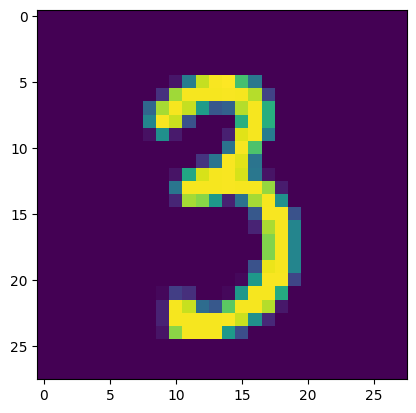

In [937]:
dataset = datasets.MNIST('.', download=True)
plt.imshow(dataset.data[98].detach().numpy())
plt.show()

In [938]:
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
len_train = len(train_set)
len_validate = len(val_set)
len_all = len(dataset)
print(f'Train set size: {len_train}, validate set size: {len_validate}, whole dataset size: {len_all}')

Train set size: 50000, validate set size: 10000, whole dataset size: 60000


In [939]:
# формирование батчка as is from the lesson
def collate_fn(data: list):
  # data = [(pic, target)...]
    pics = []
    target = []
    for item in data:
        pics.append(numpy.array(item[0]))
        if (len(item)>1):               # дорабатываю функцию для формирования batch без target
            target.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
    if True:
        target = torch.from_numpy(numpy.array(target))
        return {
              'data': pics.view(pics.size(0), -1), # B x 7xx преобразуем матрицу 28х28 в вектор 7хх
            'target': target,
            }
    # else:
    #     return {
    #        'data': pics.view(pics.size(0), -1)
    #     }

In [940]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom initsialisation nn.init.xavier_normal_(self.linear1.weight)
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, 100)

        self.linear3 = nn.Linear(100, output_dim)

        self.activation = nn.Sigmoid()

    def forward(self, x):
        # Придумал
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.do1(x)
        x = self.activation(x)
        x = self.linear3(x)
        return x

In [941]:
# hyperparams полносвязная модель
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 50
batch_size = 128
early_stop_min_deviation = 0.0045 # минимальное отклонение среднего значения функция потерь за early_stop_queue_size эпох
early_stop_queue_size = 3         # минимальное количество эпох. Считаем обучение завершенным, если три эпохи подряд дают разницу межды минимальным средним значением средней loss и максимальной на величину early_stop_min_deviation

In [942]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
    super().__init__()
        # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2)
    self.bn1 = nn.BatchNorm2d(hidden_ch)
    # self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.conv3 = nn.Conv2d(hidden_ch, 5, kernel_size=3, padding=1, stride=1)
    self.classifier = nn.Linear(5 * 14 *14, output_dim)
    self.do1 = nn.Dropout(dropout_p)
    # self.do2 = nn.Dropout(dropout_p)

    self.polling = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)

    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation(x)
    x = self.do1(x)
    x = self.polling(x)
    # x = self.bn2(x)
    x = self.activation(x)
    # x = self.do2(x)
    x = self.conv3(x)
    x = self.classifier(x.view(x.size(0), -1))

    return x

In [943]:
# гиперпараметры сверточная модель
input_ch = 1
hidden_ch = 128
out_dim = 10
batch_size = 128

In [944]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [945]:
def start_train(modell: nn.Module, collate_fnn, loss_func, optim):
    train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])

    queue = Queue(early_stop_queue_size)
    # собираю пять средних значений (по батчам) функции потерь для эпохи на тестовом датасете

    enough = False

    for epoch in range(n_epochs):
        optim.zero_grad()
        if enough:
            print('Enough flag is here. No reason to spin further epochs')
            break
        dataloader_train = DataLoader(train_set,
                                batch_size,
                                shuffle=True,
                                collate_fn=collate_fnn,
                                drop_last = True,
                                )

        dataloader_test = DataLoader(val_set,
                                     batch_size,
                                     shuffle=True,
                                     collate_fn=collate_fnn,
                                     drop_last=True)

        for i, batch in enumerate(dataloader_train):
            optim.zero_grad()
            predict = modell(batch['data'].to(device))
            loss = loss_func(predict, batch['target'].to(device))
            loss.backward()
            optim.step()
            # прячу "стату" с урока
            # if i % 200 == 0:
            #     print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')

        loss_arr_by_banches = np.array([])
        for j, batch_test in enumerate(dataloader_test):
            predict = modell(batch_test['data'].to(device))
            loss = loss_func(predict, batch_test['target'].to(device))
            loss_arr_by_banches = np.append(loss_arr_by_banches, loss.detach().numpy())
        current_epoch_loss = np.mean(loss_arr_by_banches)
        print(f'Epoch {epoch} mean loss for test set {current_epoch_loss}')
        if queue.full():
            queue.get()
        else:
            queue.put(current_epoch_loss)
        if queue.full():
            # считаем, что минимум early_stop_queue_size эпох нужно для обучения.
            # можно вынести в гиперпараметры
            as_arr = np.array(queue.queue)
            arr_max = np.amax(as_arr)
            arr_min = np.amin(as_arr)
            if arr_max - arr_min < early_stop_min_deviation:
                print(f'Means of loss function for the last {early_stop_queue_size} epochs: {as_arr}')
                print(f'Min mean of loss: {np.mean(as_arr)}')
                enough = True
            else:
                print(f'Current max/min difference in last {early_stop_queue_size} epochs: {arr_max-arr_min}')


In [946]:
loss_func = nn.CrossEntropyLoss()

### Запуск полносвязной модели

In [947]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train()
optim = torch.optim.Adam(model.parameters())
#start_train(model, collate_fn, loss_func, optim)

минимальные полученные значения loss: [0.07143388 0.06926835 0.07277913]

In [948]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
start_train(model_conv, collate_fn_conv, loss_func, optim)

Epoch 0 mean loss for test set 0.08649822821219762
Epoch 1 mean loss for test set 0.08844302444217297
Epoch 2 mean loss for test set 0.0747675126275191
Current max/min difference in last 3 epochs: 0.013675511814653873


KeyboardInterrupt: 